In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from msh_chunk import Chunk
from model import Model, Vert

from PIL import Image
import struct
import glm
import moderngl as mgl
from pathlib import Path
from ipywidgets import interact
import ipywidgets as widgets
from IPython import display

In [2]:
# If ctx is already defined, do nothing
try:
    ctx
except NameError:
    ctx = mgl.create_context(standalone=True)
ctx.gc_mode = 'auto'
ctx.enable(mgl.DEPTH_TEST | mgl.CULL_FACE | mgl.BLEND)

In [3]:
# file = Chunk('_lvl_pc/side/imp/msh/imp_fly_tiefighter.msh')
file = Chunk('_lvl_pc/side/rep/msh/rep_hover_fightertank.msh')
print(file.tree())

HEDR:
    MSH2:
        SINF:
            NAME: rep_hover_fightertank
            FRAM: 00 00 00 00 01 00 00 00 9f c2 ef 41
            BBOX: <len: 44>
        MATL:
            MATD:
                NAME: default_material
                DATA: <len: 52>
                ATRB: 04 00 00 00
            MATD:
                NAME: material1
                DATA: <len: 52>
                ATRB: 00 1b 00 00
                TX0D: rep_hover_fightertank.tga
                TX1D: rep_hover_fightertank_bump.tga
        MODL:
            MTYP: 0
            MNDX: 0
            NAME: dummyroot
            FLGS: 1
            TRAN: <len: 40>
        MODL:
            MTYP: 3
            MNDX: 1
            NAME: bone_root
            PRNT: dummyroot
            FLGS: 1
            TRAN: <len: 40>
        MODL:
            MTYP: 3
            MNDX: 2
            NAME: bone_tankski_R
            PRNT: bone_root
            FLGS: 1
            TRAN: <len: 40>
        MODL:
            MTYP: 3
         

In [4]:
segm = max(file.filter_all('SEGM'), key=lambda x: x.length)
print(segm.tree())

SEGM:
    MATI: 1
    POSL: <len: 36964>
    WGHT: <len: 98564>
    NRML: <len: 36964>
    UV0L: <len: 24644>
    NDXL: <len: 33748>
    NDXT: <len: 12660>
    STRP: <len: 7120>


In [5]:
m = Model()

vert_count = segm['POSL'].data_len()
assert vert_count == segm['NRML'].data_len() and vert_count == segm['UV0L'].data_len()
posl = struct.iter_unpack('<3f', segm['POSL'].data[4:4+12*vert_count])
nrml = struct.iter_unpack('<3f', segm['NRML'].data[4:4+12*vert_count])
uv0l = struct.iter_unpack('<2f', segm['UV0L'].data[4:4+8*vert_count])
for pos, norm, uv in zip(posl, nrml, uv0l):
    m.add_vert(Vert(glm.vec3(pos), glm.vec3(norm), glm.vec2(uv)))

tri_count = segm['NDXT'].data_len()
tris = struct.iter_unpack('<3H', segm['NDXT'].data[4:4+tri_count*6])
for tri in tris:
    m.add_tri(*tri)

In [6]:
glm.max([x.uv for x in m.verts])

vec2( 0.999993, 0.000218987 )

In [7]:
filename = './out/' + file.filter_all('SINF')[0]['NAME'].data.decode().rstrip('\0')
m.to_obj(filename + '.obj')
print(f'Saved {filename}.obj')
m.to_stl(filename + '.stl')
print(f'Saved {filename}.stl')

Saved ./out/rep_hover_fightertank.obj
Saved ./out/rep_hover_fightertank.stl


In [8]:
prog = ctx.program(
    vertex_shader=Path('./shaders/viewer.vert').read_text(),
    geometry_shader=Path('./shaders/viewer.geom').read_text(),
    fragment_shader=Path('./shaders/viewer.frag').read_text(),
)

vbo_pos, vbo_norm, vbo_uv, ibo = m.buffers(ctx)

vao = ctx.vertex_array(prog, [
        (vbo_pos, '3f', 'pos'),
        (vbo_norm, '3f', 'norm'),
        (vbo_uv, '2f', 'uv'),
    ],
    index_buffer=ibo,
    index_element_size=4
)

In [9]:
img = Image.open('_lvl_pc/side/rep/textures/rep_hover_fightertank.tga')
mainTex = ctx.texture(img.size, 4, img.tobytes(), alignment=4)
mainTex.use()

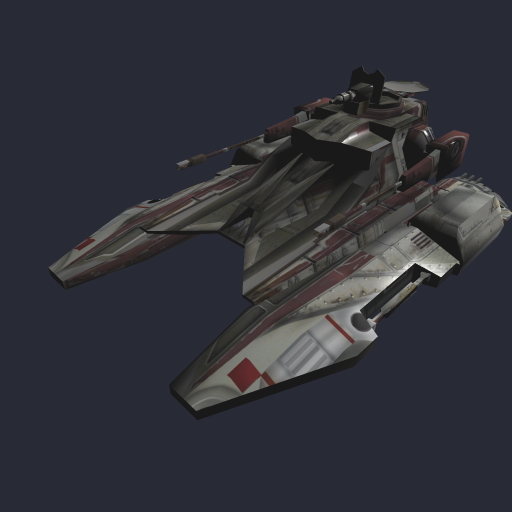

In [10]:
resolution = (512, 512)
msaa = 4
fbo = ctx.simple_framebuffer((resolution[0] * msaa, resolution[1] * msaa))

model = glm.mat4(1)
view = glm.lookAt((4, 4, 4), (0, 0, 0), (0, 1, 0))
proj = glm.perspective(glm.radians(60), 1, 0.1, 100.0)
modelView = view * model
modelViewN = view * glm.transpose(glm.inverse(model))

prog['lightPos'] = 50, 50, 0
prog['lightAmb'] = 1, 1, 1
prog['lightDiff'] = 1, 1, 1
prog['lightSpec'] = 1, 1, 1

prog['matAmb'] = 0.1, 0.1, 0.1
prog['matDiff'] = 0.8, 0.8, 0.8
prog['matSpec'] = 1.0, 1.0, 1.0
prog['matShine'] = 128

prog['wireframeColor'] = glm.vec4(255, 85, 85, 255) / 255
prog['wireframeWidth'] = 0.001

prog['useWireframe'] = 0
prog['useSmoothShading'] = 1
prog['useTextureMap'] = 1

prog['mainTex'] = 0

prog['modelView'].write(modelView.to_bytes())
prog['modelViewN'].write(modelViewN.to_bytes())
prog['view'].write(view.to_bytes())
prog['proj'].write(proj.to_bytes())

fbo.use()
fbo.clear(*(glm.vec4(40, 42, 54, 255) / 255))
vao.render()

img = Image.frombytes('RGB', fbo.size, fbo.read(), 'raw', 'RGB', 0, -1)
img = img.reduce(msaa)
img

In [11]:
default_pos = glm.vec3(4, 4, 4)
default_radius = glm.sqrt(glm.dot(default_pos, default_pos))
default_inclination = glm.pi() - glm.acos(default_pos.y / default_radius)
default_azimuth = glm.sign(default_pos.z) * glm.acos(default_pos.x /
                                                     (glm.sqrt(default_pos.x**2 + default_pos.z**2)))

resolution = (1024, 768)
msaa = 4
fbo = ctx.simple_framebuffer((resolution[0] * msaa, resolution[1] * msaa))
proj = glm.perspective(glm.radians(
    60), resolution[0] / resolution[1], 0.1, 100.0)
prog['proj'].write(proj.to_bytes())

def func(radius=default_radius, inclination=default_inclination, azimuth=default_azimuth, center_x=0,
         center_y=0, center_z=0, wireframe='Enabled', lighting='Flat', textures='Main'):
    center = glm.vec3(center_x, center_y, center_z)
    offset = radius * glm.vec3(glm.sin(inclination) * glm.sin(-azimuth),
                               -glm.cos(inclination),
                               glm.sin(inclination) * glm.cos(-azimuth))

    view = glm.lookAt(center + offset, center, (0, 1, 0))
    modelView = view * model
    modelViewN = view * glm.transpose(glm.inverse(model))
    prog['modelView'].write(modelView.to_bytes())
    prog['modelViewN'].write(modelViewN.to_bytes())

    prog['useWireframe'] = wireframe == 'Enabled'
    prog['useSmoothShading'] = lighting == 'Smooth'
    prog['useTextureMap'] = textures == 'Main'

    fbo.use()
    fbo.clear(*(glm.vec4(40, 42, 54, 255) / 255))
    vao.render()
    img = Image.frombytes('RGB', fbo.size, fbo.read(), 'raw', 'RGB', 0, -1)
    img = img.reduce(msaa)
    display.display(img)


interact(func,
         radius=(0, 10, 0.01),
         inclination=(0, glm.pi(), 0.01),
         azimuth=(-glm.two_pi(), glm.two_pi(), 0.01),
         center_x=(-5, 5, 0.01),
         center_y=(-5, 5, 0.01),
         center_z=(-5, 5, 0.01),
         wireframe=widgets.ToggleButtons(options=['Enabled', 'Disabled']),
         lighting=widgets.ToggleButtons(options=['Flat', 'Smooth']),
         textures=widgets.ToggleButtons(options=['Main', 'None']))


interactive(children=(FloatSlider(value=6.928203230275509, description='radius', max=10.0, step=0.01), FloatSl…

<function __main__.func(radius=6.928203230275509, inclination=2.186276035465284, azimuth=0.7853981633974484, center_x=0, center_y=0, center_z=0, wireframe='Enabled', lighting='Flat', textures='Main')>

TODO: https://dspace5.zcu.cz/bitstream/11025/11198/1/Mao.pdf